<a href="https://colab.research.google.com/github/moustafa-7/Fashion_MNIST_Classification_PyTorch/blob/master/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install GPUtil 

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [0]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import time

In [0]:
from torchvision import datasets, transforms

# Defining Transforms for normalization

transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.FashionMNIST('MNIST_data/',download = True, train = True, transform = transforms)
testset = datasets.FashionMNIST('MNIST_data/',download = True, train = False, transform = transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)


In [9]:
iter = iter(trainloader)
images, labels = iter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


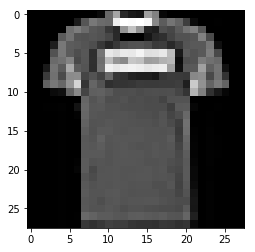

In [10]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [18]:

# GPU check
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.8 GB  | Proc size: 412.3 MB
GPU RAM Free: 11430MB | Used: 11MB | Util   0% | Total 11441MB


**Normal Model**

In [25]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

start_time = time.time()
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 (28 * 28) long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    
    
    
print("--- %s seconds ---" % (time.time() - start_time))

Epoch: 1/30.. Training loss: 0.511.. Test loss: 0.436.. Test Accuracy: 0.840
Epoch: 2/30.. Training loss: 0.380.. Test loss: 0.391.. Test Accuracy: 0.861
Epoch: 3/30.. Training loss: 0.342.. Test loss: 0.385.. Test Accuracy: 0.856
Epoch: 4/30.. Training loss: 0.321.. Test loss: 0.370.. Test Accuracy: 0.867
Epoch: 5/30.. Training loss: 0.304.. Test loss: 0.366.. Test Accuracy: 0.871
Epoch: 6/30.. Training loss: 0.289.. Test loss: 0.363.. Test Accuracy: 0.871
Epoch: 7/30.. Training loss: 0.274.. Test loss: 0.346.. Test Accuracy: 0.872
Epoch: 8/30.. Training loss: 0.267.. Test loss: 0.350.. Test Accuracy: 0.879
Epoch: 9/30.. Training loss: 0.254.. Test loss: 0.341.. Test Accuracy: 0.880
Epoch: 10/30.. Training loss: 0.245.. Test loss: 0.335.. Test Accuracy: 0.880
Epoch: 11/30.. Training loss: 0.235.. Test loss: 0.354.. Test Accuracy: 0.884
Epoch: 12/30.. Training loss: 0.228.. Test loss: 0.368.. Test Accuracy: 0.883
Epoch: 13/30.. Training loss: 0.222.. Test loss: 0.363.. Test Accuracy: 0

**Adding Batch Normalization**

In [27]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

start_time = time.time()

model = nn.Sequential(nn.Linear(784, 256),
                      nn.BatchNorm1d(256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.BatchNorm1d(128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.BatchNorm1d(64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss() we can use this one

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    
    
    
print("--- %s seconds with batchnormalization added ---" % (time.time() - start_time))

Epoch: 1/30.. Training loss: 0.571.. Test loss: 0.422.. Test Accuracy: 0.845
Epoch: 2/30.. Training loss: 0.409.. Test loss: 0.365.. Test Accuracy: 0.865
Epoch: 3/30.. Training loss: 0.371.. Test loss: 0.352.. Test Accuracy: 0.872
Epoch: 4/30.. Training loss: 0.348.. Test loss: 0.334.. Test Accuracy: 0.879
Epoch: 5/30.. Training loss: 0.333.. Test loss: 0.342.. Test Accuracy: 0.877
Epoch: 6/30.. Training loss: 0.314.. Test loss: 0.330.. Test Accuracy: 0.882
Epoch: 7/30.. Training loss: 0.304.. Test loss: 0.318.. Test Accuracy: 0.885
Epoch: 8/30.. Training loss: 0.293.. Test loss: 0.317.. Test Accuracy: 0.887
Epoch: 9/30.. Training loss: 0.282.. Test loss: 0.307.. Test Accuracy: 0.889
Epoch: 10/30.. Training loss: 0.273.. Test loss: 0.307.. Test Accuracy: 0.892
Epoch: 11/30.. Training loss: 0.269.. Test loss: 0.317.. Test Accuracy: 0.887
Epoch: 12/30.. Training loss: 0.259.. Test loss: 0.301.. Test Accuracy: 0.894
Epoch: 13/30.. Training loss: 0.255.. Test loss: 0.311.. Test Accuracy: 0

**Adding Dropout**

In [26]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

start_time = time.time()
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    
    
    
print("--- %s seconds with dropout added ---" % (time.time() - start_time))

Epoch: 1/30.. Training loss: 0.592.. Test loss: 0.479.. Test Accuracy: 0.825
Epoch: 2/30.. Training loss: 0.454.. Test loss: 0.409.. Test Accuracy: 0.849
Epoch: 3/30.. Training loss: 0.422.. Test loss: 0.428.. Test Accuracy: 0.849
Epoch: 4/30.. Training loss: 0.397.. Test loss: 0.402.. Test Accuracy: 0.859
Epoch: 5/30.. Training loss: 0.385.. Test loss: 0.382.. Test Accuracy: 0.860
Epoch: 6/30.. Training loss: 0.371.. Test loss: 0.376.. Test Accuracy: 0.867
Epoch: 7/30.. Training loss: 0.363.. Test loss: 0.377.. Test Accuracy: 0.863
Epoch: 8/30.. Training loss: 0.357.. Test loss: 0.371.. Test Accuracy: 0.870
Epoch: 9/30.. Training loss: 0.349.. Test loss: 0.381.. Test Accuracy: 0.865
Epoch: 10/30.. Training loss: 0.345.. Test loss: 0.366.. Test Accuracy: 0.867
Epoch: 11/30.. Training loss: 0.338.. Test loss: 0.358.. Test Accuracy: 0.874
Epoch: 12/30.. Training loss: 0.333.. Test loss: 0.360.. Test Accuracy: 0.876
Epoch: 13/30.. Training loss: 0.327.. Test loss: 0.364.. Test Accuracy: 0

In [0]:
# Adjusting the batch size using 32 and 128 this time

 **The 32 batch size**

In [0]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle = True)

start_time = time.time()

model = nn.Sequential(nn.Linear(784, 256),
                      nn.BatchNorm1d(256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.BatchNorm1d(128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.BatchNorm1d(64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss() we can use this one

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    
    
    
print("--- %s seconds with batch size = 32  ---" % (time.time() - start_time))

Epoch: 1/30.. Training loss: 0.575.. Test loss: 0.416.. Test Accuracy: 0.847
Epoch: 2/30.. Training loss: 0.435.. Test loss: 0.368.. Test Accuracy: 0.866
Epoch: 3/30.. Training loss: 0.396.. Test loss: 0.361.. Test Accuracy: 0.872
Epoch: 4/30.. Training loss: 0.373.. Test loss: 0.342.. Test Accuracy: 0.875
Epoch: 5/30.. Training loss: 0.356.. Test loss: 0.339.. Test Accuracy: 0.877
Epoch: 6/30.. Training loss: 0.341.. Test loss: 0.325.. Test Accuracy: 0.880
Epoch: 7/30.. Training loss: 0.330.. Test loss: 0.322.. Test Accuracy: 0.883
Epoch: 8/30.. Training loss: 0.320.. Test loss: 0.320.. Test Accuracy: 0.884


**The 128 batch size**

In [0]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = True)

start_time = time.time()

model = nn.Sequential(nn.Linear(784, 256),
                      nn.BatchNorm1d(256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.BatchNorm1d(128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.BatchNorm1d(64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss() we can use this one

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    
    
    
print("--- %s seconds with batch size = 128  ---" % (time.time() - start_time))

**A function to change learning rate**

In [0]:
def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [40]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

start_time = time.time()
lr = 0.002
model = nn.Sequential(nn.Linear(784, 256),
                      nn.BatchNorm1d(256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.BatchNorm1d(128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.BatchNorm1d(64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss() we can use this one

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

#lambda1 = lambda e: e // 30
#lambda2 = lambda e: 0.95 ** e
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])


# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  lr  = lr* 0.1 ** (e // 10)
  optimizer = adjust_learning_rate(optimizer, lr)
  #schduler.step()
  
  
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    
    
    
print("--- %s seconds with learning rate changed ---" % (time.time() - start_time))

Epoch: 1/30.. Training loss: 0.573.. Test loss: 0.411.. Test Accuracy: 0.851
Epoch: 2/30.. Training loss: 0.411.. Test loss: 0.371.. Test Accuracy: 0.865
Epoch: 3/30.. Training loss: 0.372.. Test loss: 0.348.. Test Accuracy: 0.874
Epoch: 4/30.. Training loss: 0.347.. Test loss: 0.333.. Test Accuracy: 0.877
Epoch: 5/30.. Training loss: 0.330.. Test loss: 0.331.. Test Accuracy: 0.880
Epoch: 6/30.. Training loss: 0.315.. Test loss: 0.319.. Test Accuracy: 0.887
Epoch: 7/30.. Training loss: 0.303.. Test loss: 0.321.. Test Accuracy: 0.885
Epoch: 8/30.. Training loss: 0.294.. Test loss: 0.324.. Test Accuracy: 0.885
Epoch: 9/30.. Training loss: 0.286.. Test loss: 0.320.. Test Accuracy: 0.886
Epoch: 10/30.. Training loss: 0.278.. Test loss: 0.308.. Test Accuracy: 0.890
Epoch: 11/30.. Training loss: 0.238.. Test loss: 0.293.. Test Accuracy: 0.896
Epoch: 12/30.. Training loss: 0.227.. Test loss: 0.290.. Test Accuracy: 0.898
Epoch: 13/30.. Training loss: 0.225.. Test loss: 0.290.. Test Accuracy: 0